# Basic Model

In [2]:
import pandas as pd
import numpy as np
import datetime
import networkx as nx

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import sys
sys.path.insert(0, '../src')
import helpers as h
import visualizations as v
import time

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 300)

In [3]:
# Load and preprocess data
otc_df = h.load_bitcoin_edge_data('../data/soc-sign-bitcoinotc.csv.gz')
alpha_df = h.load_bitcoin_edge_data('../data/soc-sign-bitcoinalpha.csv.gz')
alpha_users = h.user_activity_dataframe(alpha_df)
otc_users = h.user_activity_dataframe(otc_df)

In [53]:
# Load Feature Data

df_b = pd.read_csv('../data/df_b.csv')
df_dv = pd.read_csv('../data/df_dv.csv')
df_sv = pd.read_csv('../data/df_sv.csv')
df_gf = pd.read_csv('../data/df_gf.csv')

In [70]:
df_gr = pd.read_csv('../data/alpha_with_ratee_stats.csv')
df_gr = df_gr[['rater','ratee','rating', 'date', 'class','cluster_coef','num_cliques']]
# df_gr = df_gr[['rater','ratee','rating', 'date', 'class','num_cliques']]
df_gf.drop('cluster_coef', axis=1, inplace=True)

In [75]:
cols = ['ratee','rater','date','rating','class']
features_df = pd.merge(pd.merge(pd.merge(df_gr,df_dv,on=cols),df_sv,on=cols),df_b,on=cols)
features_df.drop(['binomial_rating','color','penwidth'], axis=1, inplace=True)

KeyError: "['binomial_rating' 'color' 'penwidth'] not found in axis"

In [76]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24186 entries, 0 to 24185
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   rater                   24186 non-null  int64  
 1   ratee                   24186 non-null  int64  
 2   rating                  24186 non-null  int64  
 3   date                    24186 non-null  object 
 4   class                   24186 non-null  int64  
 5   cluster_coef            24186 non-null  float64
 6   num_cliques             24186 non-null  float64
 7   vel_24_in_pos           24186 non-null  float64
 8   vel_24_in_neg           24186 non-null  float64
 9   vel_24_in_all           24186 non-null  float64
 10  vel_24_out_pos          24186 non-null  float64
 11  vel_24_out_neg          24186 non-null  float64
 12  vel_24_out_all          24186 non-null  float64
 13  vel_24_all              24186 non-null  float64
 14  vel_48_in_pos           24186 non-null

What is the range of user numbers in the networks?

In [64]:
df = features_df
df[df['num_ratings_received']==0]['class'].sum()

260

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
# X = alpha_with_ratee_stats.copy()
# X = X.drop(['rater', 'ratee', 'rating','date', 'color', 'penwidth', 'binomial_rating'], axis=1)
X = features_df.copy()
X = X.drop(['rater', 'ratee', 'rating','date'], axis=1)
y = X.pop('class')


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, shuffle=True,
                                                    random_state=123)

RF = RandomForestClassifier(n_jobs=-1, random_state=123)
RF.fit(X_train, y_train)
y_preds = RF.predict(X_test)
recall = recall_score(y_test, y_preds)
precision = precision_score(y_test, y_preds)

# print(X_test[(y_preds==0) & (X_test['num_neg_received']>0)].head(10))
print(recall)
print(precision)
RF.feature_importances_

0.6380208333333334
0.8221476510067114


array([0.06779584, 0.17432961, 0.0025359 , 0.00934785, 0.00286073,
       0.00238474, 0.00165786, 0.00332053, 0.0041539 , 0.00569707,
       0.01031602, 0.00569107, 0.00421781, 0.00235771, 0.00567965,
       0.00660077, 0.09936411, 0.07848321, 0.06718515, 0.03978316,
       0.04478927, 0.04072625, 0.07466773, 0.08787957, 0.09319463,
       0.06497984])

Text(0.5,1,'Random Forest feature importance')

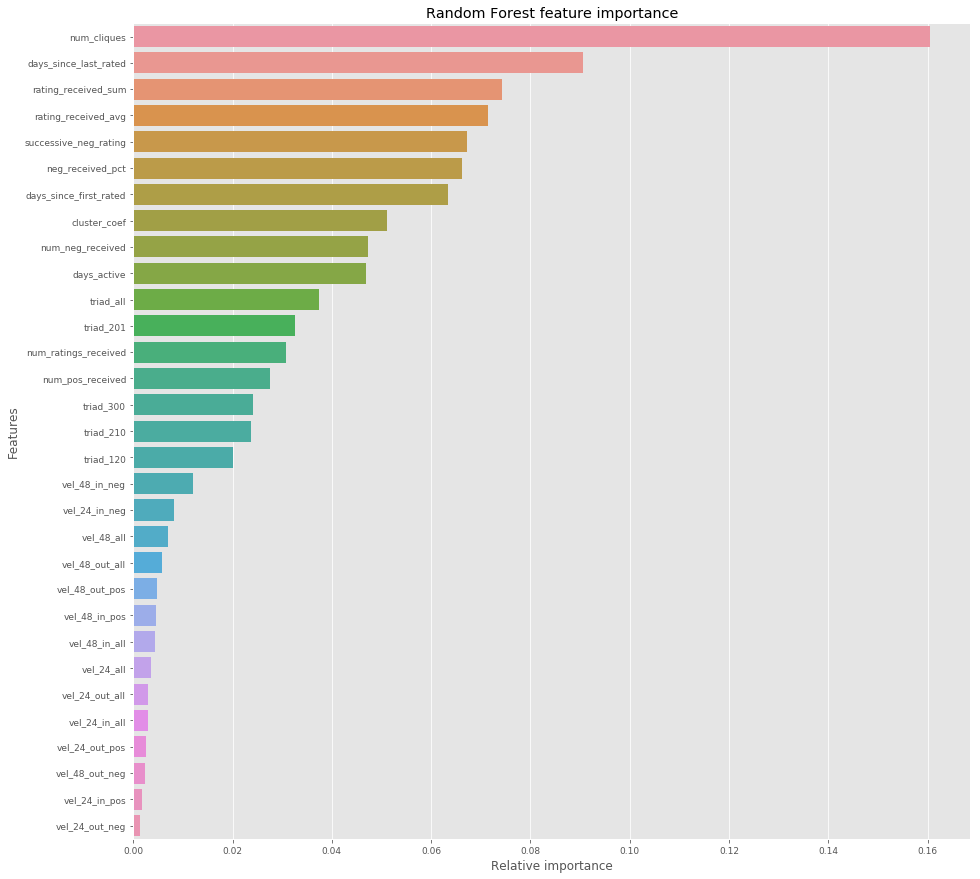

In [74]:
import seaborn as sns
fig = plt.figure(figsize=(15,15))

name = "Random Forest"
indices = np.argsort(RF.feature_importances_)[::-1][:40]
ax1 = sns.barplot(y=X_train.columns[indices][:40],x = RF.feature_importances_[indices][:40] , orient='h')
ax1.set_xlabel("Relative importance",fontsize=12)
ax1.set_ylabel("Features",fontsize=12)
ax1.tick_params(labelsize=9)
ax1.set_title(name + " feature importance")

In [ ]:
# number of unique days in dataset 
# This is the number of iterations of node2vec that will need to be run
# may take 2 days - need to test time on maximum size graph (last day)

# alpha["date"].dt.normalize().nunique()

In [ ]:
alpha['class'].mean()

In [ ]:
# first fraud
alpha_df[alpha_df['rating']<0].sort_values('date')[270:290]

In [ ]:
user_data_in = alpha_df[(alpha_df['ratee']==54) & (alpha_df['date'] < '2010-11-07 21:00:00')]

In [11]:
import time 
from datetime import datetime

def feature_creation_collusion(bitcoin_df, user, rate_date):
    df = bitcoin_df.copy()
    user_data_in = df[(df['ratee']==user) & ((df['date'] < rate_date) | ((df['date']==rate_date) & (df['rating'] > 0)))]
    if len(user_data_in)==0:
        return np.zeros(8)
    num_ratings_received = len(user_data_in)
    num_neg_received = user_data_in['class'].sum()
    num_pos_received = num_ratings_received - num_neg_received
    neg_ratings_pct = num_neg_received / num_ratings_received
    rating_sum = user_data_in['rating'].sum()
    days_active = (rate_date - user_data_in['date'].min()).days
    _, g = h.build_graph(df, maxdate=rate_date)
    cluster_coef = nx.clustering(g, user)
    g = g.to_undirected()
    num_cliques = nx.number_of_cliques(g, user)

    A = np.array([num_ratings_received, num_neg_received, num_pos_received, 
                  neg_ratings_pct, rating_sum, days_active, cluster_coef, num_cliques])
    A[np.isnan(A)] = 0
    return A

In [12]:

def feature_iteration_collusion(bitcoin_df):
    start_time = time.time()
    df = bitcoin_df.copy()
    for i, row in df.iterrows():
        user = row['ratee']
        rate_date = row['date']
        num_ratings_received, num_neg_received, num_pos_received, \
        neg_ratings_pct, rating_sum, days_active, cluster_coef, \
        num_cliques = feature_creation_collusion(df, user, rate_date)
        df.at[(i,'num_ratings_received')] = num_ratings_received
        df.at[(i,'num_neg_received')] = num_neg_received
        df.at[(i,'num_pos_received')] = num_pos_received
        df.at[(i,'neg_ratings_pct')] = neg_ratings_pct
        df.at[(i,'rating_sum')] = rating_sum
        df.at[(i,'days_active')] = days_active
        df.at[(i,'cluster_coef')] = cluster_coef
        df.at[(i,'num_cliques')] = num_cliques
        t = time.time() - start_time
        print(f"{t:.0f} seconds execution time for node {user} on {rate_date}")
    return df
alpha_with_ratee_stats = feature_iteration_collusion(alpha_df)

In [13]:
alpha_with_ratee_stats.to_csv('alpha_with_ratee_stats.csv', index=False)


In [14]:
alpha_with_ratee_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24186 entries, 1276 to 5382
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   rater                 24186 non-null  int64         
 1   ratee                 24186 non-null  int64         
 2   rating                24186 non-null  int64         
 3   date                  24186 non-null  datetime64[ns]
 4   class                 24186 non-null  int64         
 5   binomial_rating       24186 non-null  int64         
 6   color                 24186 non-null  object        
 7   penwidth              24186 non-null  int64         
 8   num_ratings_received  24186 non-null  float64       
 9   num_neg_received      24186 non-null  float64       
 10  num_pos_received      24186 non-null  float64       
 11  neg_ratings_pct       24186 non-null  float64       
 12  rating_sum            24186 non-null  float64       
 13  days_active   

In [27]:
alpha_with_ratee_stats[alpha_with_ratee_stats['rating']<0].sort_values('cluster_coef', ascending=False).head()

,rater,ratee,rating,date,class,binomial_rating,color,penwidth,num_ratings_received,num_neg_received,num_pos_received,neg_ratings_pct,rating_sum,days_active,cluster_coef,num_cliques
14394,114,7310,-1,2015-05-18 21:00:00,1,-1,red,1,1.0,0.0,1.0,0.0,1.0,2.0,1.0,1.0
3537,8,7485,-1,2013-11-30 21:00:00,1,-1,red,1,1.0,1.0,0.0,1.0,-10.0,3.0,1.0,1.0
3534,8,5446,-1,2013-11-30 21:00:00,1,-1,red,1,1.0,0.0,1.0,0.0,1.0,371.0,1.0,1.0
19159,281,3443,-1,2015-12-21 21:00:00,1,-1,red,1,1.0,0.0,1.0,0.0,1.0,90.0,1.0,1.0
22897,906,7325,-1,2015-10-31 21:00:00,1,-1,red,1,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0


In [17]:
# decision based on the existence of a negative rating
recall = recall_score(y_test, X_test['rating_sum']<0)
precision = precision_score(y_test, X_test['rating_sum']<0)
print(recall)
print(precision)

0.20052083333333334
0.8279569892473119


In [18]:
# decision based on total sum of ratings
recall = recall_score(y_test, X_test['num_neg_received']>0)
precision = precision_score(y_test, X_test['num_neg_received']>0)
print(recall)
print(precision)

0.4583333333333333
0.2561863173216885


In [1]:
# X_test[y_preds==1]

## ATO Features

In [18]:
# for bitcoin alpha - needs to be modified for bitcoin_otc
def feature_creation_ato(bitcoin_df, user, rate_date):
    df = bitcoin_df.copy()
    user_data = df[(df['ratee']==user) & ((df['date'] < rate_date) | ((df['date']==rate_date) & (df['rating'] > 0)))]
    if len(user_data) <= 1:
        return 0, 0
    else:
        days_since_last_active = (rate_date - user_data.iloc[-2]['date']).days
        if user_data.iloc[-2]['rating'] < 0:
            successive_neg_rating = 1
            if len(user_data) > 2:
                if user_data.iloc[-3]['rating'] < 0:
                    successive_neg_rating = 2
                    if len(user_data) > 3:
                        if user_data.iloc[-4]['rating'] < 0:
                            successive_neg_rating = 3
        else:
            successive_neg_rating = 0
    return days_since_last_active, successive_neg_rating

In [21]:
def feature_iteration_ato(bitcoin_df):
    df = bitcoin_df.copy()
    df = df[['rater', 'ratee','rating','date']]
    for i, row in df.iterrows():
        user = row['ratee']
        rate_date = row['date']
        days_since_last_active, successive_neg_rating = feature_creation_ato(df, user, rate_date)
        df.at[(i,'days_since_last_active')] = days_since_last_active
        df.at[(i,'successive_neg_rating')] = successive_neg_rating
    return df
alpha_features_ato = feature_iteration_ato(alpha_df)

In [22]:
alpha_features_ato

,rater,ratee,rating,date,days_since_last_active,successive_neg_rating
1276,2,402,1,2010-11-07 21:00:00,0.0,0.0
10469,113,54,4,2010-11-07 21:00:00,0.0,0.0
4004,10,970,8,2010-11-07 21:00:00,0.0,0.0
4005,10,271,8,2010-11-07 21:00:00,0.0,0.0
10468,119,54,5,2010-11-09 21:00:00,2.0,0.0
...,...,...,...,...,...,...
21812,1202,604,1,2016-01-15 21:00:00,196.0,0.0
19152,281,3450,1,2016-01-15 21:00:00,0.0,0.0
14393,114,7370,-1,2016-01-16 21:00:00,0.0,0.0
13594,3451,98,5,2016-01-21 21:00:00,22.0,0.0
